In [71]:
import numpy as np
from scipy.optimize import fsolve

# %matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
# print(plt.style.available)  # show available template
plt.style.use(['seaborn-ticks','seaborn-paper'])  # use a templet

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'
params = {
    'figure.figsize': [8, 6], # Note! figure unit is inch!  scale fontz size 2.54 to looks like unit cm
    'axes.labelsize': 8*2.54, # scale 2.54 to change to figure unit looks as cm
    'font.size':  8*2.54,
    'lines.linewidth':2,
    'axes.linewidth': 1.0,  # default 1.25
    'legend.fontsize': 6*2.54,
    'xtick.labelsize': 8*2.54,
    'ytick.labelsize': 8*2.54,
    'text.usetex': False,  
    'xtick.direction': "in",
    'ytick.direction': "in", # ticket inside
    'legend.frameon' : True, 
    'legend.edgecolor': 'black',
    'legend.shadow': True,
    'legend.framealpha':1,
#     'patch.linewidth' : 0.5, 
}
mpl.rcParams.update(params)

In [3]:
import pylustrator
pylustrator.start()

In [3]:
def carry_PHS(state, theta, chi):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2)-1j*np.sin(theta/2)*np.sin(chi), -np.sin(theta/2)*np.cos(chi)],[np.sin(theta/2)*np.cos(chi), np.cos(theta/2)+1j*np.sin(theta/2)*np.sin(chi)]])
	final_state = np.dot(U, state)

	return final_state    

def carry(state, theta):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	final_state = np.dot(U, state)

	return final_state

def blue_carry(state, theta):
	'''
	blue carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number plus 1
	|1>-->|0>, phonon number minus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, down level minus 1
	up_state = carry_state_up[0]
	down_state_minus = carry_state_up[1]
	down_state_minus_0 = state_up[0][0]  # blue carry can not drive the phonon=0 && up level
	down_state_minus = np.delete(down_state_minus, 0)
	down_state_minus = np.insert(down_state_minus, len(down_state_minus)-1, 0)
	# after U operation, up level plus 1
	up_state_plus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_plus = np.insert(up_state_plus, 0, down_state_minus_0)
	up_state_plus = np.delete(up_state_plus, len(up_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_plus
	down = down_state_minus + down_state
	final_state = np.vstack((up, down))

	return final_state

def red_carry(state, theta):
	'''
	red carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number minus 1
	|1>-->|0>, phonon number plus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, up level minus 1
	up_state_minus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_minus_0 = state_down[1][0] # red carry can not drive the phonon=0 && down level
	up_state_minus = np.delete(up_state_minus,0)
	up_state_minus = np.insert(up_state_minus,len(up_state_minus)-1,0)
	# after U operation, down level plus 1
	up_state = carry_state_up[0]
	down_state_plus = carry_state_up[1]
	down_state_plus = np.insert(down_state_plus,0,up_state_minus_0)
	down_state_plus = np.delete(down_state_plus,len(down_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_minus
	down = down_state_plus + down_state
	final_state = np.vstack((up, down))

	return final_state

def Operator(up_state, down_state, func, theta):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = func(state, theta)

	return state[0], state[1]

def operator(up_state, down_state, theta, chi):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = carry_PHS(state, theta, chi)

	return state[0], state[1]

def one_step_1(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T2R2T1R1
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_1)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, red_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_2)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, blue_carry, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def one_step_2(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state


def one_step_3(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r1T2R2T1r1  r1=sqrt(R1)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_1/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_2)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, theta_1/2)
	
	state = np.vstack((up_state, down_state, aux_state))
	return state

def one_step_4(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r2T1R1T2r2  r2=sqrt(R2)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	
	state = np.vstack((up_state, down_state, aux_state))
	return state

def One_step_1(state, theta_1, theta_2, chi):
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = operator(up_state, down_state, theta_2/2, chi/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = operator(aux_state, down_state,theta_1, chi)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = operator(up_state, down_state, theta_2/2, chi/2)
	
	state = np.vstack((up_state, down_state, aux_state))
	return state
	
	state = np.vstack((up_state, down_state, aux_state))
	return state

def One_step_2(state, theta_1, theta_2, chi):
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = operator(aux_state, down_state, theta_1, chi)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	
	state = np.vstack((up_state, down_state, aux_state))
	return state
	
	state = np.vstack((up_state, down_state, aux_state))
	return state


def n_step_1(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_1(state, theta_1, theta_2)
	return state

def n_step_2(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2(state, theta_1, theta_2)
	return state

def n_step_3(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2(state, theta_1, theta_2)
	return state

def n_step_4(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2(state, theta_1, theta_2)
	return state

def n_step(state, theta_1, theta_2, chi, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step(state, theta_1, theta_2, chi)
	return state

In [4]:
def neighbour(theta_1, theta_2, theta_3, init_state):
    p_1 = np.zeros(M+1)
    p_2 = np.zeros(M+1)
    p_3 = np.zeros(M+1)
    p_4 = np.zeros(M+1)
    p_5 = np.zeros(M+1)
    p_1[0]=1
    p_2[0]=1
    p_3[0]=1
    p_4[0]=1
    p_5[0]=1
    for i in range(n1): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)
            state2 = one_step_4(init_state, theta_1, theta_2)
            state3 = one_step_4(init_state, theta_1, theta_2)
            state4 = one_step_4(init_state, theta_1, theta_2)
            state5 = one_step_4(init_state, theta_1, theta_2)
        else:
            state1 = one_step_4(state1, theta_1, theta_2)
            state2 = one_step_4(state2, theta_1, theta_2) 
            state3 = one_step_4(state3, theta_1, theta_2) 
            state4 = one_step_4(state4, theta_1, theta_2)
            state5 = one_step_4(state5, theta_1, theta_2)
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+1] = P1[0] + P1[1]
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+1] = P1[0] + P1[1] 
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+1] = P3[0] + P3[1] 
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+1] = P4[0] + P4[1]
        P5 = abs(state5[0])**2 + abs(state5[1])**2 + abs(state5[2])**2
        p_5[i+1] = P5[0] + P5[1] 

    for i in range(n2+n3):
        t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_1))       
        state1 = one_step_4(state1, theta_1, t1)
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+n1+1] = P1[0] + P1[1]
        t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_2))       
        state2 = one_step_4(state2, theta_1, t2)
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+n1+1] = P2[0] + P2[1]
        t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_3))       
        state3 = one_step_4(state3, theta_1, t3)
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+n1+1] = P3[0] + P3[1]
        t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_4))       
        state4 = one_step_4(state4, theta_1, t4)
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+n1+1] = P4[0] + P4[1]
        state5 = one_step_4(state5, theta_1, theta_3)
        P5 = abs(state5[0])**2 + abs(state5[1])**2 + abs(state5[2])**2
        p_5[i+n1+1] = P5[0] + P5[1]
        
    return p_1,p_2,p_3,p_4,p_5

In [5]:
def Neighbour(theta_1, theta_2, theta_3, init_state):
    p_1 = np.zeros(M+1)
    p_2 = np.zeros(M+1)
    p_3 = np.zeros(M+1)
    p_4 = np.zeros(M+1)
    p_5 = np.zeros(M+1)
    p_1[0]=1
    p_2[0]=1
    p_3[0]=1
    p_4[0]=1
    p_5[0]=1
    for i in range(n1): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)
            state2 = one_step_4(init_state, theta_1, theta_2)
            state3 = one_step_4(init_state, theta_1, theta_2)
            state4 = one_step_4(init_state, theta_1, theta_2)
            state5 = one_step_4(init_state, theta_1, theta_2)
        else:
            state1 = one_step_4(state1, theta_1, theta_2)
            state2 = one_step_4(state2, theta_1, theta_2) 
            state3 = one_step_4(state3, theta_1, theta_2) 
            state4 = one_step_4(state4, theta_1, theta_2)
            state5 = one_step_4(state5, theta_1, theta_2)
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+1] = P1[0] + P1[1]
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+1] = P1[0] + P1[1] 
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+1] = P3[0] + P3[1] 
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+1] = P4[0] + P4[1]
        P5 = abs(state5[0])**2 + abs(state5[1])**2 + abs(state5[2])**2
        p_5[i+1] = P5[0] + P5[1] 

    for i in range(n2):
        t1 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi_1))       
        state1 = one_step_4(state1, t1, theta_2)
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+n1+1] = P1[0] + P1[1]
        t2 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi_2))       
        state2 = one_step_4(state2, t2, theta_2)
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+n1+1] = P2[0] + P2[1]
        t3 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi_3))       
        state3 = one_step_4(state3, t3, theta_2)
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+n1+1] = P3[0] + P3[1]
        t4 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi_4))       
        state4 = one_step_4(state4, t4, theta_2)
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+n1+1] = P4[0] + P4[1]
    
    for i in range(n3):
        t1 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi_1))     
        state1 = one_step_4(state1, t1, theta_2)   
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+n1+n2+1] = P1[0] + P1[1]  
        t2 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi_2))     
        state2 = one_step_4(state2, t2, theta_2)   
        P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
        p_2[i+n1+n2+1] = P2[0] + P2[1]
        t3 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi_3))     
        state3 = one_step_4(state3, t3, theta_2)   
        P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
        p_3[i+n1+n2+1] = P3[0] + P3[1]
        t4 = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi_4))     
        state4 = one_step_4(state4, t4, theta_2)   
        P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
        p_4[i+n1+n2+1] = P4[0] + P4[1]
    for i in range(n2+n3):
        state5 = one_step_4(state5, theta_3, theta_2)
        P5 = abs(state5[0])**2 + abs(state5[1])**2 + abs(state5[2])**2
        p_5[i+n1+1] = P5[0] + P5[1]
        return p_1,p_2,p_3,p_4,p_5

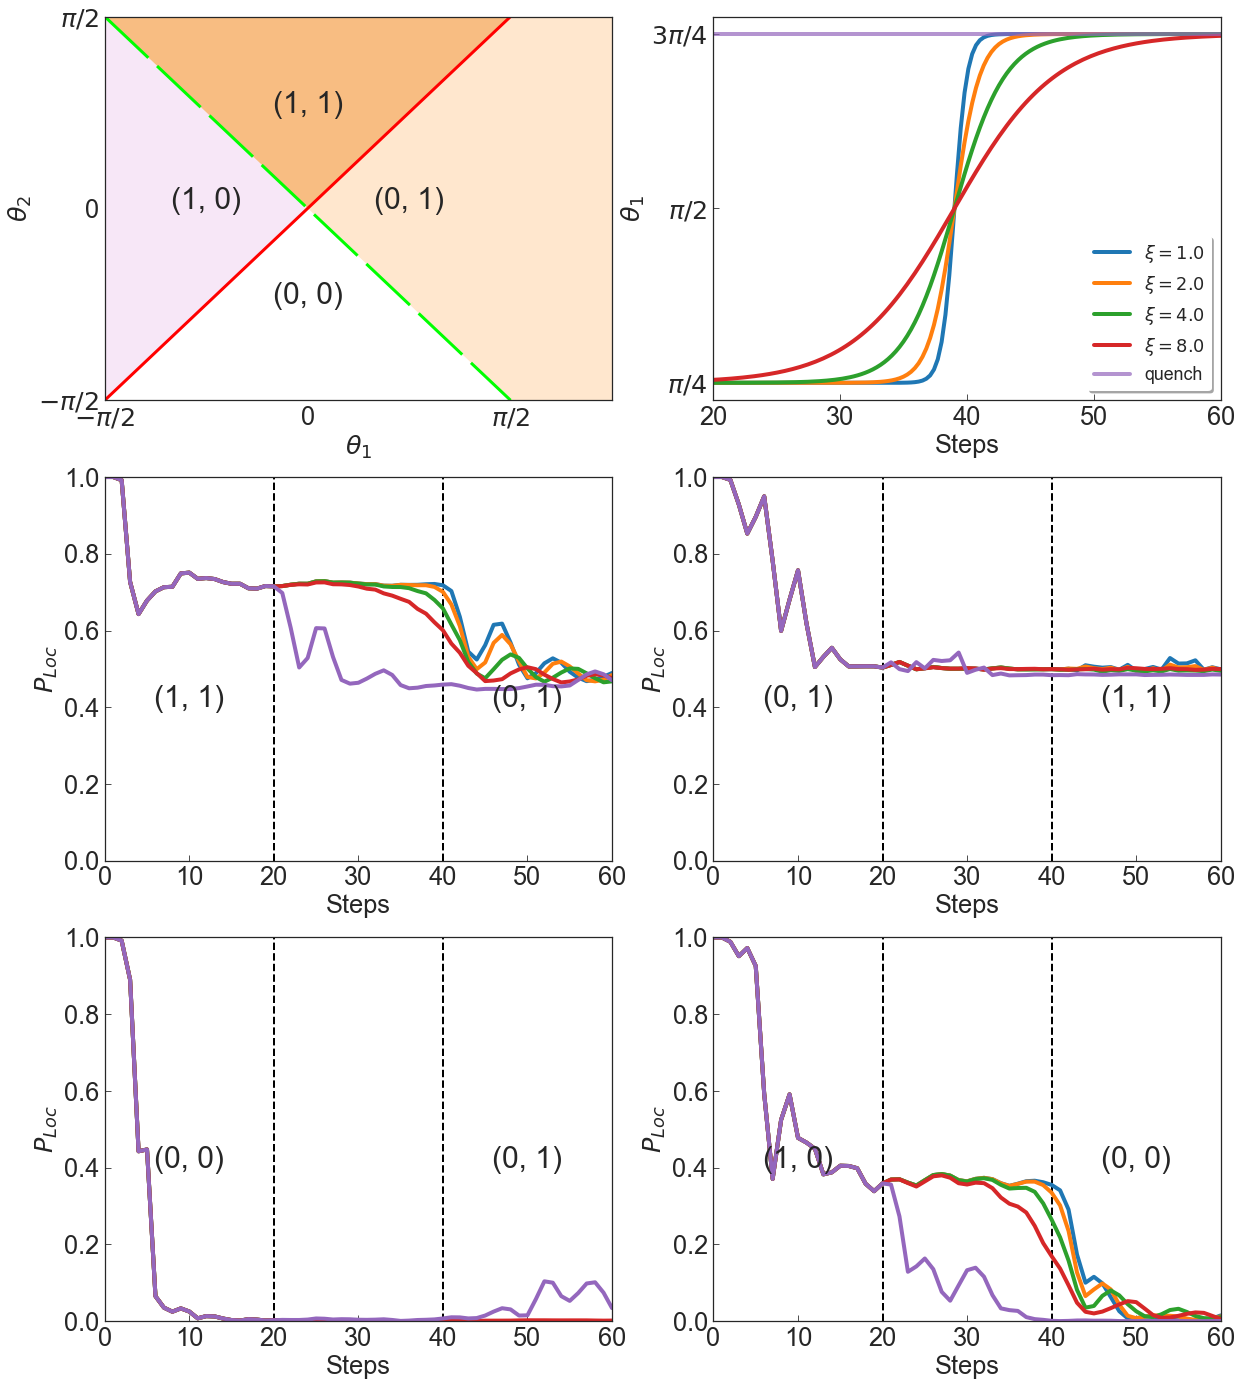

In [28]:

M = 200

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

n1 = 20
n2 = 20
n3 = 20
xi_1=1
xi_2=2
xi_3=4
xi_4=8

plt.figure(figsize=(20,24))
plt.subplot(3,2,2)
# 波形 ,theta_1 为后半段转角，theta_2 为前半段转角，xi越小演化越慢
theta_3 = 3*np.pi/4
theta_1 = np.pi/2
theta_2 = np.pi/4
def f(t, theta_1, theta_2, xi, n1):
    return 1/2*(theta_1+theta_2 + (theta_1-theta_2)*np.tanh((t-n1)/xi))
T = np.linspace(0,n1+n2+n3,200)
plt.xlim(n1,n1+n2+n3)
plt.xlabel('Steps')
plt.ylabel(r'$\theta_1$')
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4, 0], (r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', '0'))
plt.plot(T,f(T, theta_3, theta_2, xi_1, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_1))
plt.plot(T,f(T, theta_3, theta_2, xi_2, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_2))
plt.plot(T,f(T, theta_3, theta_2, xi_3, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_3))
plt.plot(T,f(T, theta_3, theta_2, xi_4, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_4))
plt.plot(T,theta_3*np.ones(200),lw=4,alpha=0.7,label='quench')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)

plt.subplot(3,2,1)
plt.xlim((-np.pi/2, 5*np.pi/4-np.pi/2))
plt.xticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
plt.ylim((-np.pi/2, np.pi/2))
plt.yticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
T4 = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(T4, T4, c='r', linewidth=3)
line_6, = plt.plot(T4, -T4, c='#00FF00', linewidth=3, linestyle="-")
line_6.set_dashes((20,4))
plt.fill([0, -np.pi/2, np.pi/2], [0, np.pi/2, np.pi/2], color='#F8BD82')
plt.fill([0, np.pi/2, 3*np.pi/4, 3*np.pi/4, np.pi/2], [0, np.pi/2, np.pi/2, -np.pi/2, -np.pi/2], color='#FFE7CE')
plt.fill([0, np.pi/2, -2*np.pi], [0, -np.pi/2, -np.pi/2], color='w')
plt.fill([0, -np.pi/2, -np.pi/2], [0, np.pi/2, -np.pi/2], c='#F7E7F7')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.text(0, np.pi/4, '(1, 1)', ha='center', fontsize=30)
plt.text(-np.pi/4, 0, '(1, 0)', ha='center', fontsize=30)
plt.text(np.pi/4, 0, '(0, 1)', ha='center', fontsize=30)
plt.text(0, -np.pi/4, '(0, 0)', ha='center', fontsize=30)
A=[np.pi/4, np.pi/2]
B=[np.pi/4, -np.pi/2]

plt.subplot(3,2,3)
theta_3 = 3*np.pi/4
theta_1 = np.pi/2
theta_2 = np.pi/4

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
p_5 =  neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4)
plt.plot(T, p_2,lw=4)
plt.plot(T, p_3,lw=4)
plt.plot(T, p_4,lw=4)
plt.plot(T, p_5,lw=4)
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(1, 1)', ha='center', fontsize=30)
plt.text(50, 0.4, '(0, 1)', ha='center', fontsize=30)
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')

plt.subplot(3,2,4)
theta_3 = np.pi/4
theta_1 = np.pi/2
theta_2 = 3*np.pi/4+0.2

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
p_5 =  neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4)
plt.plot(T, p_2,lw=4)
plt.plot(T, p_3,lw=4)
plt.plot(T, p_4,lw=4)
plt.plot(T, p_5,lw=4)
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(0, 1)', ha='center', fontsize=30)
plt.text(50, 0.4, '(1, 1)', ha='center', fontsize=30)
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')

plt.subplot(3,2,5)
theta_3 = 3*np.pi/4
theta_1 = -np.pi/2
theta_2 = np.pi/4

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
p_5 =  neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4)
plt.plot(T, p_2,lw=4)
plt.plot(T, p_3,lw=4)
plt.plot(T, p_4,lw=4)
plt.plot(T, p_5,lw=4)
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(0, 0)', ha='center', fontsize=30)
plt.text(50, 0.4, '(0, 1)', ha='center', fontsize=30)
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')

plt.subplot(3,2,6)
theta_3 = np.pi/4
theta_1 = -np.pi/2
theta_2 = 3*np.pi/4

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
p_5 =  neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4)
plt.plot(T, p_2,lw=4)
plt.plot(T, p_3,lw=4)
plt.plot(T, p_4,lw=4)
plt.plot(T, p_5,lw=4)
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(1, 0)', ha='center', fontsize=30)
plt.text(50, 0.4, '(0, 0)', ha='center', fontsize=30)
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')
plt.savefig('fig_10.pdf')

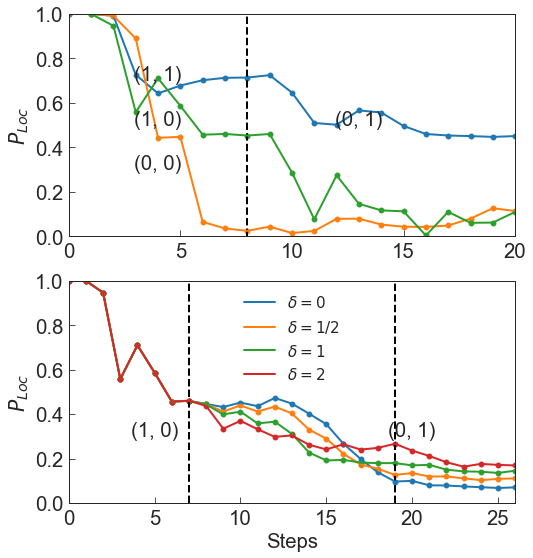

In [73]:
plt.figure(figsize=(8,9))
plt.subplot(2,1,1)
n1 = 8
n2 = 12
n3 = 0
theta_3 = 3*np.pi/4
theta_1 = np.pi/2
theta_2 = np.pi/4
p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
n1 = 8
n2 = 12
n3 = 0
theta_3 = 3*np.pi/4
theta_1 = -np.pi/2
theta_2 = np.pi/4
n1 = 8
n2 = 12
n3 = 0
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
theta_3 = np.pi/2
theta_1 = np.pi/4
theta_2 = -np.pi/2
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1)
plt.scatter(range(21), p_1)
plt.plot(T, p_2)
plt.scatter(range(21), p_2)
plt.plot(T, p_3)
plt.scatter(range(21), p_3)
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.text(4, 0.7, '(1, 1)', ha='center')
plt.text(13, 0.5, '(0, 1)', ha='center')
plt.text(4, 0.3, '(0, 0)', ha='center')
plt.text(4, 0.5, '(1, 0)', ha='center')
plt.ylabel(r'$P_{Loc}$')
plt.subplot(2,1,2)
n1=7
n2=6
n3=6
n4=7
T = range(n1+n2+n3+n4+1)
n=50
dis=1
pp_1 = np.zeros(n1+n2+n3+n4+1)
pp_2 = np.zeros(n1+n2+n3+n4+1)
pp_3 = np.zeros(n1+n2+n3+n4+1)
pp_4 = np.zeros(n1+n2+n3+n4+1)
p1=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p1[i][0]=1
for i in range(n):
    pp_1 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], 0) + pp_1
    
p2=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p2[i][0]=1
for i in range(n):
    pp_2 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis) + pp_2

p3=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p3[i][0]=1
for i in range(n):
    pp_3 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*2) + pp_3

p4=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p4[i][0]=1
for i in range(n):
    pp_4 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*4) + pp_4

plt.plot(T, pp_1/n,label=r'$\delta=0$')
plt.scatter(range(n1+n2+n3+n4+1), pp_1/n)
plt.plot(T, pp_2/n,label=r'$\delta=1/2$')
plt.scatter(range(n1+n2+n3+n4+1), pp_2/n)
plt.plot(T, pp_3/n,label=r'$\delta=1$')
plt.scatter(range(n1+n2+n3+n4+1), pp_3/n)
plt.plot(T, pp_4/n,label=r'$\delta=2$')
plt.scatter(range(n1+n2+n3+n4+1), pp_4/n)
plt.xlim((0,n1+n2+n3+n4))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2+n3, 0, 1, linestyles = "dashed")
plt.xlabel('Steps')
plt.ylabel(r'$P_{Loc}$')
plt.text(5, 0.3, '(1, 0)', ha='center')
plt.text(20, 0.3, '(0, 1)', ha='center')
leg = plt.legend(frameon=False,loc='upper center')
leg.get_frame().set_linewidth(0.0)
plt.savefig('../fig/phase_ap_2.pdf')


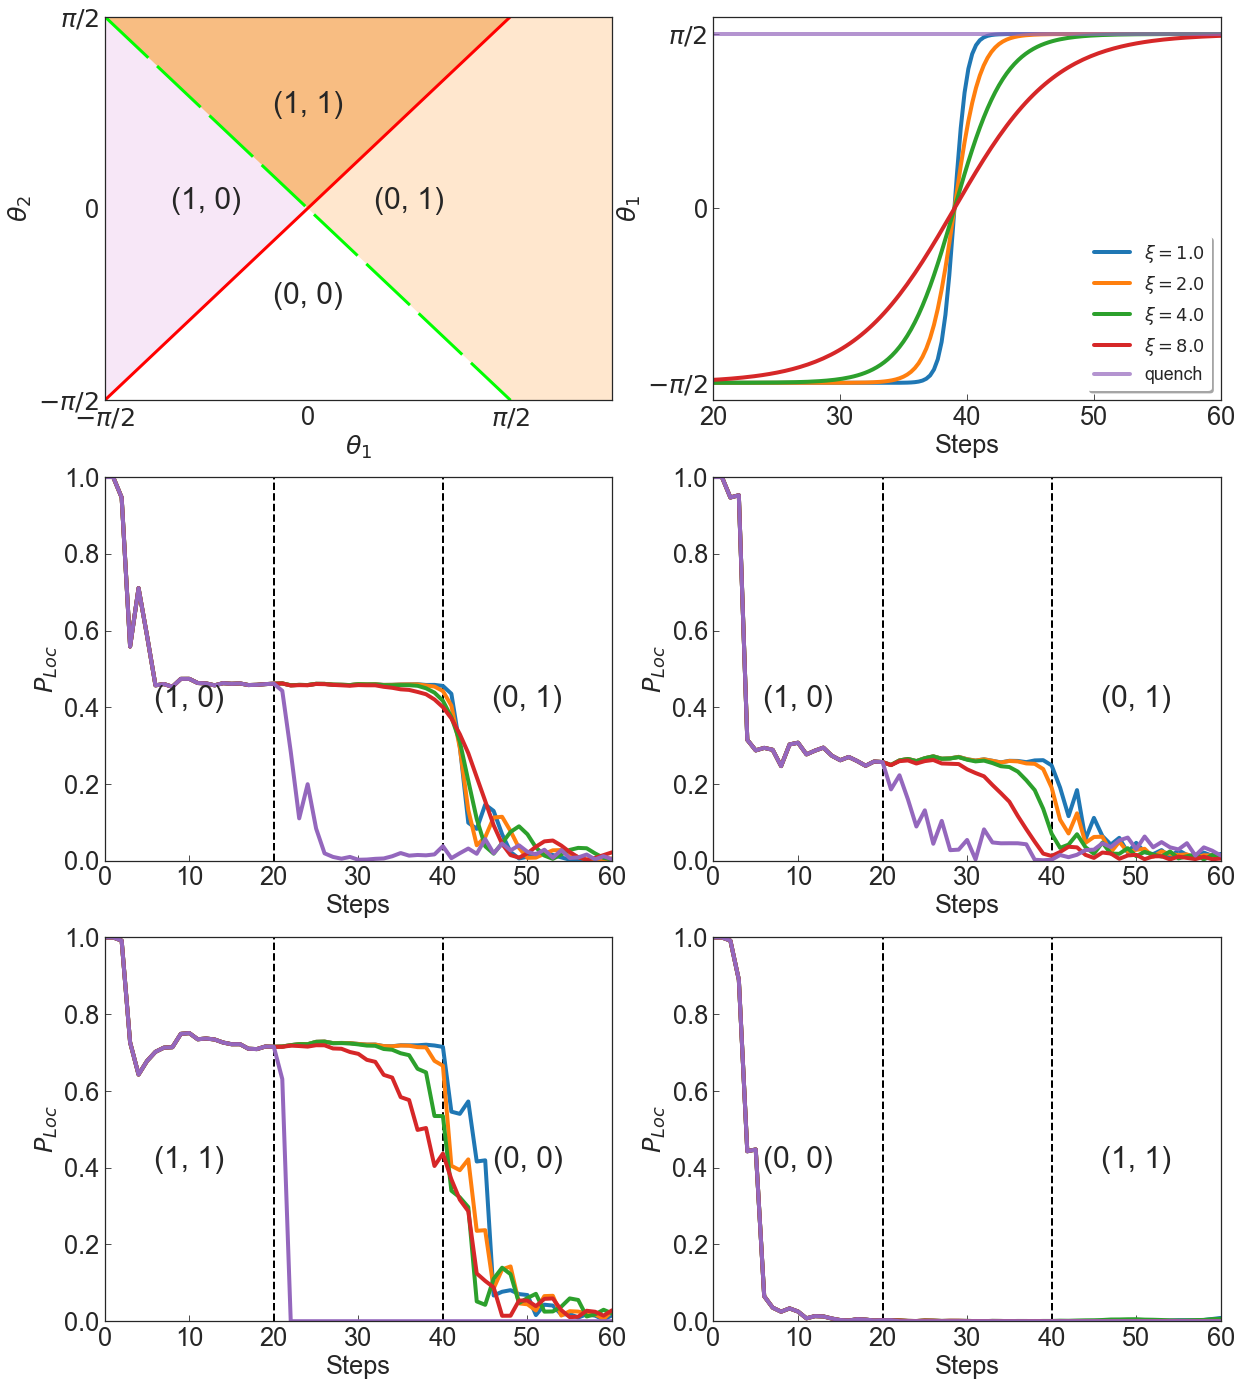

In [39]:

M = 200

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

n1 = 20
n2 = 20
n3 = 20
xi_1=1
xi_2=2
xi_3=4
xi_4=8

plt.figure(figsize=(20,24))
plt.subplot(3,2,2)
# 波形 ,theta_1 为后半段转角，theta_2 为前半段转角，xi越小演化越慢
theta_3 = np.pi/2
theta_1 = 0
theta_2 = -np.pi/2
def f(t, theta_1, theta_2, xi, n1):
    return 1/2*(theta_1+theta_2 + (theta_1-theta_2)*np.tanh((t-n1)/xi))
T = np.linspace(0,n1+n2+n3,200)
plt.xlim(n1,n1+n2+n3)
plt.xlabel('Steps')
plt.ylabel(r'$\theta_1$')
plt.yticks([np.pi/2, -np.pi/2, 0], (r'$\pi/2$', r'$-\pi/2$', '0'))
plt.plot(T,f(T, theta_3, theta_2, xi_1, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_1))
plt.plot(T,f(T, theta_3, theta_2, xi_2, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_2))
plt.plot(T,f(T, theta_3, theta_2, xi_3, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_3))
plt.plot(T,f(T, theta_3, theta_2, xi_4, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_4))
plt.plot(T,theta_3*np.ones(200),lw=4,alpha=0.7,label='quench')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)

plt.subplot(3,2,1)
plt.xlim((-np.pi/2, 5*np.pi/4-np.pi/2))
plt.xticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
plt.ylim((-np.pi/2, np.pi/2))
plt.yticks([-np.pi/2, np.pi/2, 0], ('$-\pi/2$', '$\pi/2$', '0'))
T4 = np.linspace(-np.pi/2, np.pi/2, 50)
plt.plot(T4, T4, c='r', linewidth=3)
line_6, = plt.plot(T4, -T4, c='#00FF00', linewidth=3, linestyle="-")
line_6.set_dashes((20,4))
plt.fill([0, -np.pi/2, np.pi/2], [0, np.pi/2, np.pi/2], color='#F8BD82')
plt.fill([0, np.pi/2, 3*np.pi/4, 3*np.pi/4, np.pi/2], [0, np.pi/2, np.pi/2, -np.pi/2, -np.pi/2], color='#FFE7CE')
plt.fill([0, np.pi/2, -2*np.pi], [0, -np.pi/2, -np.pi/2], color='w')
plt.fill([0, -np.pi/2, -np.pi/2], [0, np.pi/2, -np.pi/2], c='#F7E7F7')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.text(0, np.pi/4, '(1, 1)', ha='center', fontsize=30)
plt.text(-np.pi/4, 0, '(1, 0)', ha='center', fontsize=30)
plt.text(np.pi/4, 0, '(0, 1)', ha='center', fontsize=30)
plt.text(0, -np.pi/4, '(0, 0)', ha='center', fontsize=30)
A=[np.pi/4, np.pi/2]
B=[np.pi/4, -np.pi/2]

plt.subplot(3,2,3)
theta_3 = np.pi/2
theta_1 = np.pi/4
theta_2 = -np.pi/2

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
p_5 =  neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4)
plt.plot(T, p_2,lw=4)
plt.plot(T, p_3,lw=4)
plt.plot(T, p_4,lw=4)
plt.plot(T, p_5,lw=4)
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(1, 0)', ha='center', fontsize=30)
plt.text(50, 0.4, '(0, 1)', ha='center', fontsize=30)
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')

plt.subplot(3,2,4)
theta_3 = np.pi/2
theta_1 = -np.pi/4
theta_2 = -np.pi/2

p_1 =  neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
p_5 =  neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4)
plt.plot(T, p_2,lw=4)
plt.plot(T, p_3,lw=4)
plt.plot(T, p_4,lw=4)
plt.plot(T, p_5,lw=4)
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(1, 0)', ha='center', fontsize=30)
plt.text(50, 0.4, '(0, 1)', ha='center', fontsize=30)
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')

plt.subplot(3,2,5)
theta_2 = np.pi/4
theta_1 = np.pi/2
theta_3 = -np.pi/2

p_1 =  Neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  Neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  Neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  Neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
p_5 =  Neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4)
plt.plot(T, p_2,lw=4)
plt.plot(T, p_3,lw=4)
plt.plot(T, p_4,lw=4)
plt.plot(T, p_5,lw=4)
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(1, 1)', ha='center', fontsize=30)
plt.text(50, 0.4, '(0, 0)', ha='center', fontsize=30)
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')

plt.subplot(3,2,6)
theta_2 = np.pi/4
theta_1 = -np.pi/2
theta_3 = np.pi/2

p_1 =  Neighbour(theta_1, theta_2, theta_3, init_state)[0][0:n1+n2+n3+1]
p_2 =  Neighbour(theta_1, theta_2, theta_3, init_state)[1][0:n1+n2+n3+1]
p_3 =  Neighbour(theta_1, theta_2, theta_3, init_state)[2][0:n1+n2+n3+1]
p_4 =  Neighbour(theta_1, theta_2, theta_3, init_state)[3][0:n1+n2+n3+1]
p_5 =  Neighbour(theta_1, theta_2, theta_3, init_state)[4][0:n1+n2+n3+1]
T = range(n1+n2+n3+1)
plt.plot(T, p_1,lw=4)
plt.plot(T, p_2,lw=4)
plt.plot(T, p_3,lw=4)
plt.plot(T, p_4,lw=4)
plt.plot(T, p_5,lw=4)
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.text(10, 0.4, '(0, 0)', ha='center', fontsize=30)
plt.text(50, 0.4, '(1, 1)', ha='center', fontsize=30)
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')
plt.savefig('fig_11.pdf')

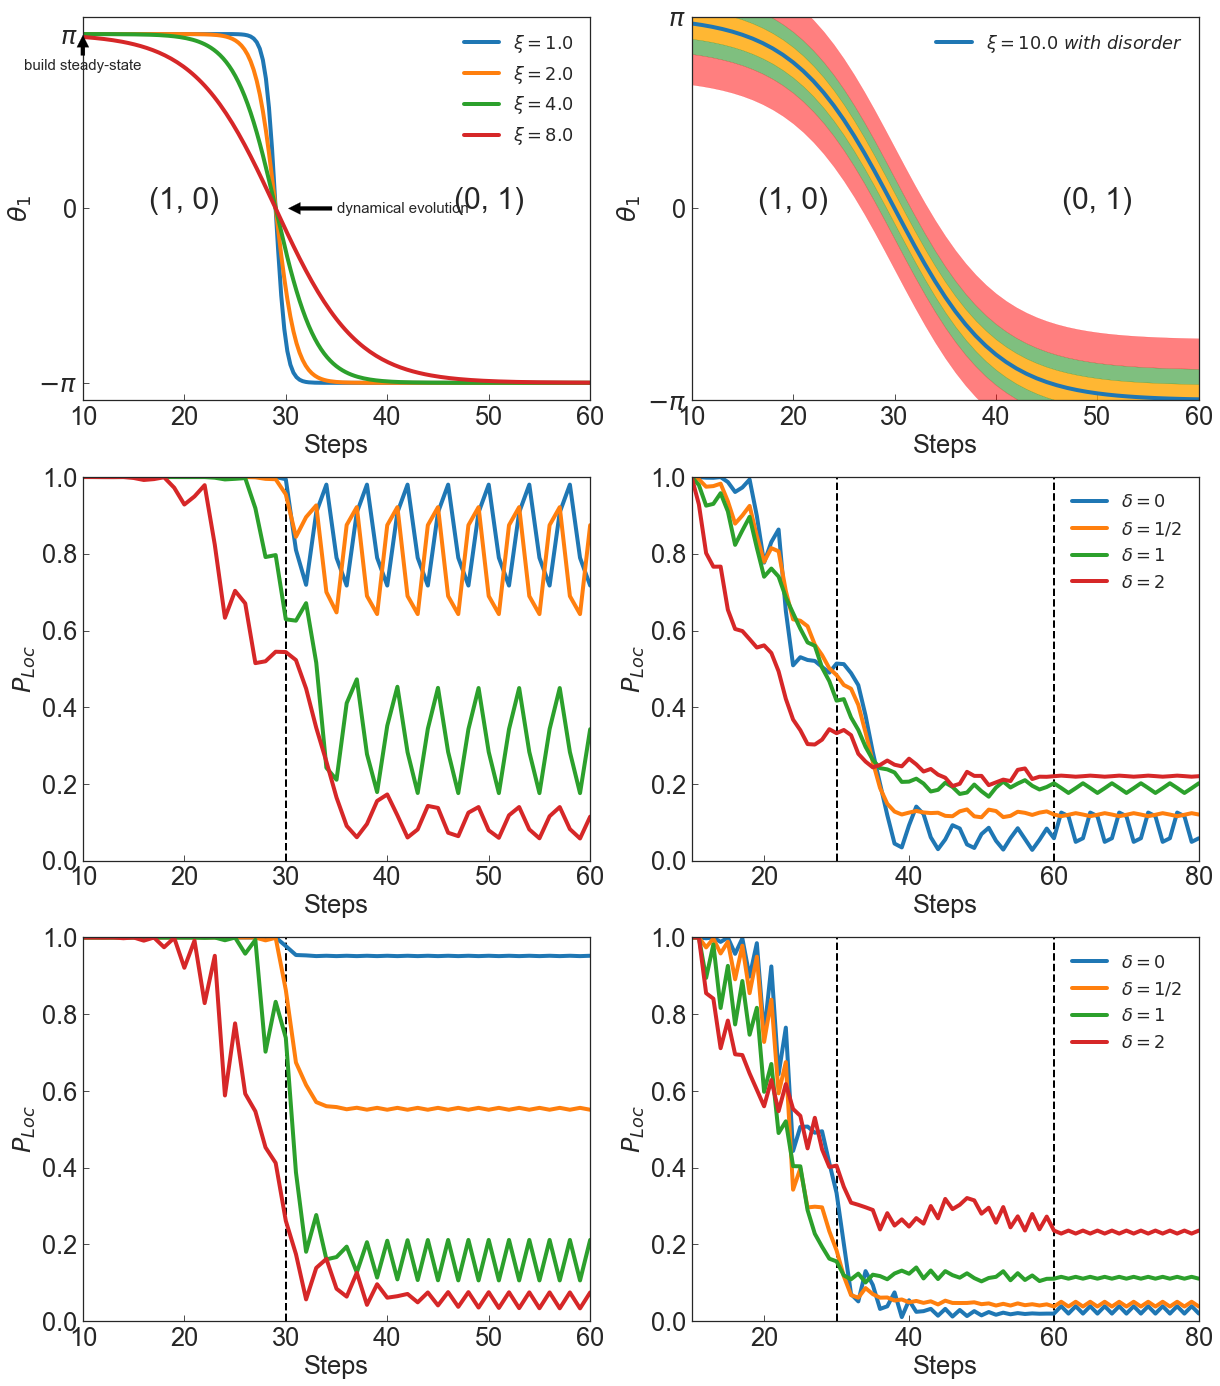

In [16]:
M = 200

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_3 = -np.pi
theta_1 = np.pi/2
theta_2 = np.pi

n1=10
n2=20
n3=30
n4=20
xi_1=1
xi_2=2
xi_3=4
xi_4=8

p_1 = np.zeros(M+1)
p_2 = np.zeros(M+1)
p_3 = np.zeros(M+1)
p_4 = np.zeros(M+1)
p_5 = np.zeros(M+1)
 
p_1[0]=1
p_2[0]=1
p_3[0]=1
p_4[0]=1
p_5[0]=1

plt.figure(figsize=(20,24))
plt.subplot(3,2,1)
# 波形 ,theta_1 为后半段转角，theta_2 为前半段转角，xi越小演化越慢
n = 30
def f(t, theta_1, theta_2, xi, n1):
    return 1/2*(theta_1+theta_2 + (theta_1-theta_2)*np.tanh((t-n1)/xi))
T = np.linspace(0,n1+n2+n3,n1+n2+n3+1)
T = np.linspace(0,n1+n2+n3,200)
plt.xlim(n1,n1+n2+n3)
plt.xlabel('Steps')
plt.ylabel(r'$\theta_1$')
plt.plot(T,f(T, theta_3, theta_2, xi_1, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_1))
plt.plot(T,f(T, theta_3, theta_2, xi_2, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_2))
plt.plot(T,f(T, theta_3, theta_2, xi_3, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_3))
plt.plot(T,f(T, theta_3, theta_2, xi_4, n1+n2-1),lw=4,label=r'$\xi=%.1f$'%(xi_4))
plt.yticks([-np.pi, np.pi, 0], (r'$-\pi$', r'$\pi$', '0'))
plt.annotate('build steady-state', xy=(10, np.pi),xytext=(10, 2.5),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=15,ha='center',)
plt.annotate('dynamical evolution', xy=(30, 0),xytext=(35, 0),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=15,va='center',)
plt.text(20, 0, '(1, 0)', ha='center', fontsize=30)
plt.text(50, 0, '(0, 1)', ha='center', fontsize=30)
leg = plt.legend(frameon=False)
leg.get_frame().set_linewidth(0.0)

plt.subplot(3,2,3)

for i in range(n1): 
    if (i == 0):
        state1 = one_step_4(init_state, theta_1, theta_2)
        state2 = one_step_4(init_state, theta_1, theta_2)
        state3 = one_step_4(init_state, theta_1, theta_2)
        state4 = one_step_4(init_state, theta_1, theta_2)
    else:
        state1 = one_step_4(state1, theta_1, theta_2)
        state2 = one_step_4(state2, theta_1, theta_2) 
        state3 = one_step_4(state3, theta_1, theta_2) 
        state4 = one_step_4(state4, theta_1, theta_2) 
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+1] = P1[0] + P1[1]
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+1] = P1[0] + P1[1] 
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+1] = P3[0] + P3[1] 
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+1] = P4[0] + P4[1] 


for i in range(n2):
    t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_1))       
    state1 = one_step_4(state1, theta_1, t1)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+n1+1] = P1[0] + P1[1]
    t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_2))       
    state2 = one_step_4(state2, theta_1, t2)
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+n1+1] = P2[0] + P2[1]
    t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_3))       
    state3 = one_step_4(state3, theta_1, t3)
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+n1+1] = P3[0] + P3[1]
    t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_4))       
    state4 = one_step_4(state4, theta_1, t4)
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+n1+1] = P4[0] + P4[1]
    
for i in range(n3):
    t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_1))     
    state1 = one_step_4(state1, theta_1, t1)   
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+n1+n2+1] = P1[0] + P1[1]  
    t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_2))     
    state2 = one_step_4(state2, theta_1, t2)   
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+n1+n2+1] = P2[0] + P2[1]
    t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_3))     
    state3 = one_step_4(state3, theta_1, t3)   
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+n1+n2+1] = P3[0] + P3[1]
    t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_4))     
    state4 = one_step_4(state4, theta_1, t4)   
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+n1+n2+1] = P4[0] + P4[1]
    
T = range(n1+n2+n3+1)
plt.plot(T, p_1[0:n1+n2+n3+1],lw=4)
plt.plot(T, p_2[0:n1+n2+n3+1],lw=4)
plt.plot(T, p_3[0:n1+n2+n3+1],lw=4)
plt.plot(T, p_4[0:n1+n2+n3+1],lw=4)
plt.xlim((10,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')


import random
M = 200
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))



dis=1
xi=10
n=30



p_1 = np.zeros(n1+n2+n3+n4+1)
p_2 = np.zeros(n1+n2+n3+n4+1)
p_3 = np.zeros(n1+n2+n3+n4+1)
p_4 = np.zeros(n1+n2+n3+n4+1)


plt.subplot(3,2,2)
# 波形 ,theta_1 为后半段转角，theta_2 为前半段转角，xi越小演化越慢

def f(t, theta_1, theta_2, xi, n1):
    return 1/2*(theta_1+theta_2 + (theta_1-theta_2)*np.tanh((t-n1)/xi))
T = np.linspace(0,n1+n2+n3,n1+n2+n3+1)
th = np.zeros(n1+n2+n3+1)
th[0:n1] = theta_2*np.ones(n1)
for i,t in enumerate(T[n1-1:-1]):
    th[i+n1] = f(t, theta_3, theta_2, xi, n1+n2-1)
plt.xlim(10,60)
plt.ylim(-np.pi, np.pi)
plt.xlabel('Steps')
plt.ylabel(r'$\theta_1$')
plt.yticks([-np.pi, np.pi, 0], (r'$-\pi$', r'$\pi$', '0'))
plt.plot(T,th,lw=4,label=r'$\xi=%.1f\ with\ disorder$'%(xi))
plt.fill_between(T, th+dis/4, th-dis/4, color='orange', alpha=0.8)
plt.fill_between(T, th+dis/4, th+dis/2, color='green', alpha=0.5)
plt.fill_between(T, th-dis/4, th-dis/2, color='green', alpha=0.5)
plt.fill_between(T, th+dis/2, th+dis, color='red', alpha=0.5)
plt.fill_between(T, th-dis/2, th-dis, color='red', alpha=0.5) 
plt.text(20, 0, '(1, 0)', ha='center', fontsize=30)
plt.text(50, 0, '(0, 1)', ha='center', fontsize=30)
leg = plt.legend(frameon=False)
leg.get_frame().set_linewidth(0.0)

plt.subplot(3,2,4)



def f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p, dis):
    for i in range(n1): 
        if (i == 0):
            state = one_step_4(init_state, theta_1, theta_2)
        else:
            state = one_step_4(state, theta_1, theta_2)
        P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
        p[i+1] = P[0] + P[1]
    for i in range(n2):
        t = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi))       
        state = one_step_4(state, theta_1, t+random.uniform(-dis,dis))
        P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
        p[i+n1+1] = P[0] + P[1]
    for i in range(n3):
        t = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi))     
        state = one_step_4(state, theta_1, t+random.uniform(-dis,dis))   
        P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
        p[i+n1+n2+1] = P[0] + P[1]
    for i in range(n4): 
        state = one_step_4(state, theta_1, theta_2)
        P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
        p[i+n1+n2+n3+1] = P[0] + P[1]
    return p
T = range(n1+n2+n3+n4+1)

p1=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p1[i][0]=1
for i in range(n):
    p_1 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], 0) + p_1
    
p2=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p2[i][0]=1
for i in range(n):
    p_2 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis) + p_2

p3=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p3[i][0]=1
for i in range(n):
    p_3 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*2) + p_3

p4=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p4[i][0]=1
for i in range(n):
    p_4 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*4) + p_4
plt.plot(T, p_1/n,lw=4,label=r'$\delta=0$')
plt.plot(T, p_2/n,lw=4,label=r'$\delta=1/2$')
plt.plot(T, p_3/n,lw=4,label=r'$\delta=1$')
plt.plot(T, p_4/n,lw=4,label=r'$\delta=2$')
plt.xlim((10,n1+n2+n3+n4))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2+n3, 0, 1, linestyles = "dashed")
plt.xlabel('Steps')
plt.ylabel(r'$P_{Loc}$')
leg = plt.legend(frameon=False)
leg.get_frame().set_linewidth(0.0)

plt.subplot(3,2,5)

theta_3 = -np.pi
theta_1 = 0
theta_2 = np.pi

for i in range(n1): 
    if (i == 0):
        state1 = one_step_4(init_state, theta_1, theta_2)
        state2 = one_step_4(init_state, theta_1, theta_2)
        state3 = one_step_4(init_state, theta_1, theta_2)
        state4 = one_step_4(init_state, theta_1, theta_2)
    else:
        state1 = one_step_4(state1, theta_1, theta_2)
        state2 = one_step_4(state2, theta_1, theta_2) 
        state3 = one_step_4(state3, theta_1, theta_2) 
        state4 = one_step_4(state4, theta_1, theta_2) 
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+1] = P1[0] + P1[1]
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+1] = P1[0] + P1[1] 
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+1] = P3[0] + P3[1] 
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+1] = P4[0] + P4[1] 


for i in range(n2):
    t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_1))       
    state1 = one_step_4(state1, theta_1, t1)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+n1+1] = P1[0] + P1[1]
    t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_2))       
    state2 = one_step_4(state2, theta_1, t2)
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+n1+1] = P2[0] + P2[1]
    t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_3))       
    state3 = one_step_4(state3, theta_1, t3)
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+n1+1] = P3[0] + P3[1]
    t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi_4))       
    state4 = one_step_4(state4, theta_1, t4)
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+n1+1] = P4[0] + P4[1]
    
for i in range(n3):
    t1 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_1))     
    state1 = one_step_4(state1, theta_1, t1)   
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+n1+n2+1] = P1[0] + P1[1]  
    t2 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_2))     
    state2 = one_step_4(state2, theta_1, t2)   
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+n1+n2+1] = P2[0] + P2[1]
    t3 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_3))     
    state3 = one_step_4(state3, theta_1, t3)   
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+n1+n2+1] = P3[0] + P3[1]
    t4 = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi_4))     
    state4 = one_step_4(state4, theta_1, t4)   
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+n1+n2+1] = P4[0] + P4[1]
    
T = range(n1+n2+n3+1)
plt.plot(T, p_1[0:n1+n2+n3+1],lw=4)
plt.plot(T, p_2[0:n1+n2+n3+1],lw=4)
plt.plot(T, p_3[0:n1+n2+n3+1],lw=4)
plt.plot(T, p_4[0:n1+n2+n3+1],lw=4)
plt.xlim((10,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.ylabel(r'$P_{Loc}$')
plt.xlabel('Steps')

plt.subplot(3,2,6)
T = range(n1+n2+n3+n4+1)
n=20
dis=1

p_1 = np.zeros(n1+n2+n3+n4+1)
p_2 = np.zeros(n1+n2+n3+n4+1)
p_3 = np.zeros(n1+n2+n3+n4+1)
p_4 = np.zeros(n1+n2+n3+n4+1)
p1=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p1[i][0]=1
for i in range(n):
    p_1 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], 0) + p_1
    
p2=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p2[i][0]=1
for i in range(n):
    p_2 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis) + p_2

p3=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p3[i][0]=1
for i in range(n):
    p_3 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*2) + p_3

p4=np.zeros((n,n1+n2+n3+n4+1))
for i in range(n):
    p4[i][0]=1
for i in range(n):
    p_4 = f_dis(theta_1, theta_2, theta_3, n1, n2, n3, n4, init_state, p1[i], dis*4) + p_4

plt.plot(T, p_1/n,lw=4,label=r'$\delta=0$')
plt.plot(T, p_2/n,lw=4,label=r'$\delta=1/2$')
plt.plot(T, p_3/n,lw=4,label=r'$\delta=1$')
plt.plot(T, p_4/n,lw=4,label=r'$\delta=2$')
plt.xlim((10,n1+n2+n3+n4))
plt.ylim(top = 1,bottom = 0)
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2+n3, 0, 1, linestyles = "dashed")
plt.xlabel('Steps')
plt.ylabel(r'$P_{Loc}$')
leg = plt.legend(frameon=False)
leg.get_frame().set_linewidth(0.0)
plt.savefig("20.pdf")

In [221]:
p_1 = np.zeros(M+1)
p_2 = np.zeros(M+1)
p_3 = np.zeros(M+1)
p_4 = np.zeros(M+1)
p_5 = np.zeros(M+1)
p_6 = np.zeros(M+1)
p_7 = np.zeros(M+1)
p_8 = np.zeros(M+1)
p_1[0]=1
p_2[0]=1
p_3[0]=1
p_4[0]=1
p_5[0]=1
p_6[0]=1
p_7[0]=1
p_8[0]=1

theta_1 = np.pi/2
theta_2 = -np.pi/4
n1=20
n2=20

for i in range(n1): 
    if (i == 0):
        state1 = one_step_2(init_state, theta_1, theta_2)
        state2 = one_step_2(init_state, theta_1, theta_2)
        state3 = one_step_2(init_state, theta_1, theta_2)
        state4 = one_step_2(init_state, theta_1, theta_2)
        state5 = one_step_2(init_state, theta_1, theta_2)
        state6 = one_step_2(init_state, theta_1, theta_2)
        state7 = one_step_2(init_state, theta_1, theta_2)
        state8 = one_step_2(init_state, theta_1, theta_2)
    else:
        state1 = one_step_2(state1, theta_1, theta_2)
        state2 = one_step_2(state2, theta_1, theta_2) 
        state3 = one_step_2(state3, theta_1, theta_2) 
        state4 = one_step_2(state4, theta_1, theta_2)
        state5 = one_step_2(state5, theta_1, theta_2)
        state6 = one_step_2(state6, theta_1, theta_2)
        state7 = one_step_2(state7, theta_1, theta_2)
        state8 = one_step_2(state8, theta_1, theta_2)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+1] = P1[0] + P1[1]
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+1] = P2[0] + P2[1] 
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+1] = P3[0] + P3[1] 
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+1] = P4[0] + P4[1]
    P5 = abs(state5[0])**2 + abs(state5[1])**2 + abs(state5[2])**2
    p_5[i+1] = P5[0] + P5[1] 
    P6 = abs(state6[0])**2 + abs(state6[1])**2 + abs(state6[2])**2
    p_6[i+1] = P6[0] + P6[1]
    P7 = abs(state7[0])**2 + abs(state7[1])**2 + abs(state7[2])**2
    p_7[i+1] = P7[0] + P7[1] 
    P8 = abs(state8[0])**2 + abs(state8[1])**2 + abs(state8[2])**2
    p_8[i+1] = P8[0] + P6[1]

for i in range(n2):  
    state1 = one_step_1(state1, theta_1, theta_2)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    p_1[i+n1+1] = P1[0] + P1[1]     
    state2 = one_step_3(state2, theta_1, theta_2)
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p_2[i+n1+1] = P2[0] + P2[1] 
    state3 = one_step_4(state3, theta_1, theta_2)
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    p_3[i+n1+1] = P3[0] + P3[1]
    state4 = One_step_1(state4, theta_1, theta_2, np.pi/4)
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p_4[i+n1+1] = P4[0] + P4[1]
    state5 = One_step_1(state5, theta_1, theta_2, np.pi/2)
    P5 = abs(state5[0])**2 + abs(state5[1])**2 + abs(state5[2])**2
    p_5[i+n1+1] = P5[0] + P5[1]
    state6 = one_step_2(state6, theta_1, theta_2)
    P6 = abs(state6[0])**2 + abs(state6[1])**2 + abs(state6[2])**2
    p_6[i+n1+1] = P6[0] + P6[1]
    state7 = One_step_2(state7, theta_1, theta_2, np.pi/4)
    P7 = abs(state7[0])**2 + abs(state7[1])**2 + abs(state7[2])**2
    p_7[i+n1+1] = P7[0] + P7[1]
    state8 = One_step_2(state8, theta_1, theta_2, np.pi/2)
    P8 = abs(state8[0])**2 + abs(state8[1])**2 + abs(state8[2])**2
    p_8[i+n1+1] = P8[0] + P8[1]
    
    

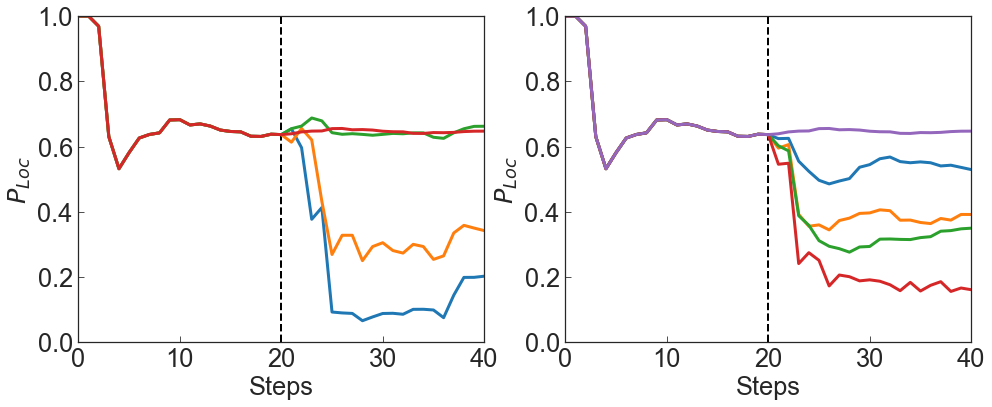

In [341]:
plt.figure(figsize=(16,6))
n1=20
n2=20
T=range(n1+n2+1)
plt.subplot(1,2,1)
plt.ylim(0,1)
plt.xlim(0,40)
plt.xlabel('Steps')
plt.ylabel(r'$P_{Loc}$')
plt.vlines(20, 0, 1, linestyles = "dashed")
plt.plot(T, p_1[0:n1+n2+1], lw=3)
plt.plot(T, p_2[0:n1+n2+1], lw=3)
plt.plot(T, p_3[0:n1+n2+1], lw=3)
plt.plot(T, p_6[0:n1+n2+1], lw=3)
plt.subplot(1,2,2)
plt.ylim(0,1)
plt.xlim(0,40)
plt.xlabel('Steps')
plt.ylabel(r'$P_{Loc}$')
plt.vlines(20, 0, 1, linestyles = "dashed")
plt.plot(T, p_4[0:n1+n2+1], lw=3)
plt.plot(T, p_5[0:n1+n2+1], lw=3)
plt.plot(T, p_7[0:n1+n2+1], lw=3)
plt.plot(T, p_8[0:n1+n2+1], lw=3)
plt.plot(T, p_6[0:n1+n2+1], lw=3)
plt.savefig("20.pdf")

In [287]:
C = np.linspace(-np.pi,np.pi,200)
theta_1 = np.pi/4
theta_2 = np.pi/2
n1=20
n2=20
pp_1 = np.zeros(M+1)
pp_2 = np.zeros(M+1)
t1 = np.zeros(200)
t2 = np.zeros(200)
for k in range(200):
    for i in range(n1): 
        if (i == 0):
            sstate1 = one_step_4(init_state, theta_1, theta_2)
            sstate2 = one_step_4(init_state, theta_1, theta_2)
        else:
            sstate1 = one_step_4(sstate1, theta_1, theta_2)
            sstate2 = one_step_4(sstate2, theta_1, theta_2)
    for j in range(n2):
        sstate1 = One_step_1(sstate1, theta_1, theta_2, C[k])
        sstate2 = One_step_2(sstate2, theta_1, theta_2, C[k])
        PP1 = abs(sstate1[0])**2 + abs(sstate1[1])**2 + abs(sstate1[2])**2
        PP2 = abs(sstate2[0])**2 + abs(sstate2[1])**2 + abs(sstate2[2])**2
    t1[k] = PP1[0] + PP1[1]
    t2[k] = PP2[0] + PP2[1]
    

In [338]:
theta_1 = np.pi/2
theta_2 = np.pi/4
a=np.zeros((31,4))
for i in range(31): 
    if (i == 0):
        sstate1 = one_step_2(init_state, theta_1, theta_2)
        sstate2 = one_step_2(init_state, theta_1, -theta_2)
    else:
        sstate1 = one_step_2(sstate1, theta_1, theta_2)
        sstate2 = one_step_2(sstate2, theta_1, -theta_2)
    a[i] = np.sign([sstate1[0][0], sstate1[1][0],sstate2[0][0], sstate2[1][0]])

(0, 30)

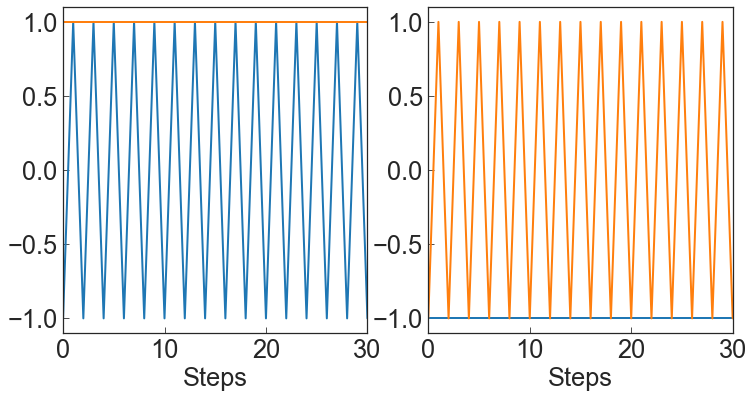

In [339]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(a.T[0])
plt.plot(a.T[1])
plt.xlabel('Steps')
plt.ylim((-1.1,1.1))
plt.xlim((0,30))
plt.subplot(1,2,2)
plt.plot(a.T[2])
plt.plot(a.T[3])
plt.xlabel('Steps')
plt.ylim((-1.1,1.1))
plt.xlim((0,30))

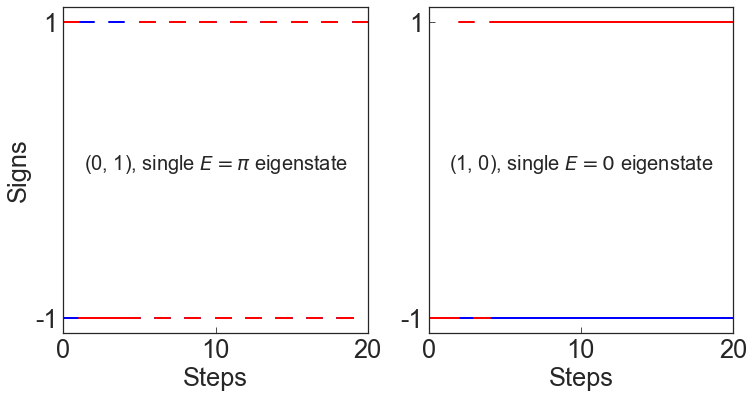

In [337]:
def plot(list, c='b'):
    for i in range(20):
        T = np.linspace(i,i+1,10)
        plt.plot(T,list[i]*np.ones(10),c=c)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.xlabel('Steps')
plt.ylabel('Signs')
plt.text(10, 0, '(0, 1), single '+r'$E=\pi$'+' eigenstate', ha='center', fontsize=20)
plt.yticks([-1, 1], (-1, 1))
plt.ylim((-1.1,1.1))
plt.xlim((0,20))
plot(a.T[0],c='b')
plot(a.T[1],c='r')
plt.subplot(1,2,2)
plt.yticks([-1, 1], (-1, 1))
plt.xlabel('Steps')
plt.text(10, 0, '(1, 0), single '+ r'$E=0$'+' eigenstate', ha='center', fontsize=20)
plt.ylim((-1.1,1.1))
plt.xlim((0,20))
plot(a.T[2],c='b')
plot(a.T[3],c='r')
plt.savefig('30.pdf')

In [239]:
from numpy import cos,sin
def f1(theta_1, theta_2, chi, k):
    return np.arccos((cos(k)*cos(theta_1/2)*cos(theta_2/2)-cos(chi)**2*sin(theta_1/2)*sin(theta_2/2)+sin((theta_1+theta_2)/2)*sin(chi)*sin(k)-cos(k)*sin(chi)**2*sin(theta_1/2)*sin(theta_2/2)))
def f2(theta_1, theta_2, chi, k):
    return np.arccos(cos(k)*cos(theta_1/2)*cos(theta_2/2)-sin(theta_1/2)*sin(theta_2/2)*cos(chi))

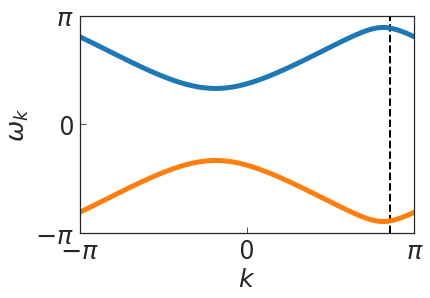

In [272]:
k = np.linspace(-np.pi, np.pi, 100)
theta_1 = np.pi/2
theta_2 = np.pi/4
plt.plot(k, f1(theta_1, theta_2, -2.69, k),lw=5)
plt.plot(k, -f1(theta_1, theta_2, -2.69, k),lw=5)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.yticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.vlines(2.69, -np.pi, np.pi, linestyles = "dashed")